# **Mounting google drive file system**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!pip install keras==2.2.5
!pip install tensorflow-gpu==1.15.2

     |████████████████████████████████| 337kB 4.6MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
     |████████████████████████████████| 411.0MB 38kB/s 
     |████████████████████████████████| 512kB 46.2MB/s 
     |████████████████████████████████| 3.8MB 48.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=f4ba34fc83e34fe0c59eec0cfb9591aea0d4efde998e92bfb250985325966091
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
 

# **Setting up constants**

In [0]:
BASE_PATH = '/content/drive/My Drive/CAI propio/male_female_hemafrodita'
TRAINING_DIR = BASE_PATH + '/training'
TEST_DIR = BASE_PATH + '/test'
SEED = 101
IMAGE_SIZE = 224
CHANNELS = 3 # red, green, blue
CLASSES = 2

#**Checking Up data**

In [4]:
# SNIPPET TO LOAD DATA FROM DIRECTORY, FOR MANUAL WORK WITHOUT GENERATORS

import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

x_data = []
images_0 = glob.glob (TRAINING_DIR + '/female/*.jpg')
images_1 = glob.glob (TRAINING_DIR + '/male/*.jpg')

print ('category 0 count ' + str(len(images_0)))
print ('category 1 count ' + str(len(images_1)))


category 0 count 13
category 1 count 13


# **Cycle Learning Rate**


In [5]:
from keras.callbacks import Callback
from keras import backend as K
import numpy as np


class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency.
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.

    The amplitude of the cycle can be scaled on a per-iteration or
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    For more detail, please see paper.

    # Example for CIFAR-10 w/ batch size 100:
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```

    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```

    # References

      - [Cyclical Learning Rates for Training Neural Networks](
      https://arxiv.org/abs/1506.01186)
    """

    def __init__(
            self,
            base_lr=0.001,
            max_lr=0.006,
            step_size=2000.,
            mode='triangular',
            gamma=1.,
            scale_fn=None,
            scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2',
                        'exp_range']:
            raise KeyError("mode must be one of 'triangular', "
                           "'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

Using TensorFlow backend.


#**Adabound custom optimizer**

In [0]:
from keras import backend as K
from keras.optimizers import Optimizer


class AdaBound(Optimizer):
    """AdaBound optimizer.

    Default parameters follow those provided in the original paper.

    # Arguments
        lr: float >= 0. Learning rate.
        final_lr: float >= 0. Final learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        gamma: float >= 0. Convergence speed of the bound function.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: Weight decay weight.
        amsbound: boolean. Whether to apply the AMSBound variant of this
            algorithm.

    # References
        - [Adaptive Gradient Methods with Dynamic Bound of Learning Rate]
          (https://openreview.net/forum?id=Bkg3g2R9FX)
        - [Adam - A Method for Stochastic Optimization]
          (https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond]
          (https://openreview.net/forum?id=ryQu7f-RZ)
    """

    def __init__(self, lr=0.001, final_lr=0.1, beta_1=0.9, beta_2=0.999, gamma=1e-3,
                 epsilon=None, decay=0., amsbound=False, weight_decay=0.0, **kwargs):
        super(AdaBound, self).__init__(**kwargs)

        if not 0. <= gamma <= 1.:
            raise ValueError("Invalid `gamma` parameter. Must lie in [0, 1] range.")

        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')

        self.final_lr = final_lr
        self.gamma = gamma

        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsbound = amsbound

        self.weight_decay = float(weight_decay)
        self.base_lr = float(lr)

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        # Applies bounds on actual learning rate
        step_size = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                          (1. - K.pow(self.beta_1, t)))

        final_lr = self.final_lr * lr / self.base_lr
        lower_bound = final_lr * (1. - 1. / (self.gamma * t + 1.))
        upper_bound = final_lr * (1. + 1. / (self.gamma * t))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsbound:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            # apply weight decay
            if self.weight_decay != 0.:
                g += self.weight_decay * K.stop_gradient(p)

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            if self.amsbound:
                vhat_t = K.maximum(vhat, v_t)
                denom = (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                denom = (K.sqrt(v_t) + self.epsilon)

            # Compute the bounds
            step_size_p = step_size * K.ones_like(denom)
            step_size_p_bound = step_size_p / denom
            bounded_lr_t = m_t * K.minimum(K.maximum(step_size_p_bound,
                                                     lower_bound), upper_bound)

            p_t = p - bounded_lr_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'final_lr': float(self.final_lr),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'gamma': float(self.gamma),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'weight_decay': self.weight_decay,
                  'amsbound': self.amsbound}
        base_config = super(AdaBound, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# **Function definitions**



*   buildModel
*   buildModelFromDisk
*   getHyperparameters
*   getTrainingHyperparameters
*   buildSampleFromDisk





## **Hyperparameters**

In [0]:
'''
  Hyperparameters used to compile the model
'''

from keras.optimizers import RMSprop, Adadelta, Adam, SGD

def getHyperparameters():
  OPTIMIZER = SGD(1e-3)
  LOSS = 'categorical_crossentropy'
  METRICS = ['categorical_accuracy']

  return (LOSS, OPTIMIZER, METRICS)

## **Training parameters**

In [0]:
'''
  Hyperparameters that are used only for training phase, e.g, number of epochs,
  batch size.
'''

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

def getTrainingHyperparameters():
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, verbose=1) 
  early_stop = EarlyStopping(patience=60, restore_best_weights=True)
  model_checkpoint = ModelCheckpoint('./checkpoint.h5', monitor='val_loss', save_best_only=True, verbose=1)
  cycle_learning_rate = CyclicLR(1e-7, 1e-1, step_size=100, mode='triangular2') 
  CALLBACK = [
    reduce_lr,
    model_checkpoint,
    early_stop
  ]

  BATCH_SIZE = 16
  EPOCHS = 500

  return (EPOCHS, BATCH_SIZE, CALLBACK)

##**buildModel**

In [0]:
'''
  Model architecture definiton, including layers, initializers, activations and more
'''

from keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Dropout, GlobalAveragePooling2D, BatchNormalization, LeakyReLU
from keras.models import Model
from keras.initializers import Constant
from keras.regularizers import l2

kernel_regularizer = l2(0.1)
activity_regularizer = l2(0.01)

def buildModel():
  i = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
  d = Conv2D(filters=16, kernel_size=(5,5), kernel_initializer='glorot_uniform', bias_initializer=Constant(0.1))(i)
  d = LeakyReLU(0.01)(d)
  d = MaxPool2D(pool_size=(2,2))(d)
  d = BatchNormalization()(d)
  d = Conv2D(filters=32, kernel_size=(5,5) , kernel_initializer='glorot_uniform', bias_initializer=Constant(0.1))(d)
  d = LeakyReLU(0.01)(d)
  d = MaxPool2D(pool_size=(2,2))(d)
  d = BatchNormalization()(d)
  d = Conv2D(filters=64, kernel_size=(3,3) , kernel_initializer='glorot_uniform', bias_initializer=Constant(0.1))(d)
  d = LeakyReLU(0.01)(d)
  d = MaxPool2D(pool_size=(2,2))(d)
  d = BatchNormalization()(d)
  d = Conv2D(filters=64, kernel_size=(3,3) , kernel_initializer='glorot_uniform', bias_initializer=Constant(0.1))(d)
  d = LeakyReLU(0.01)(d)
  d = MaxPool2D(pool_size=(2,2))(d)
  d = GlobalAveragePooling2D()(d)
  d = BatchNormalization()(d)
  d = Dense(256, activation='relu', kernel_initializer='glorot_uniform', bias_initializer=Constant(0.1), activity_regularizer=activity_regularizer)(d)
  d = Dropout(0.30)(d)
  d = Dense(CLASSES, activation='softmax', kernel_initializer='glorot_uniform', bias_initializer=Constant(0.1))(d)

  model = Model(inputs=i, outputs=d)

  (LOSS, OPTIMIZER, METRICS) = getHyperparameters()

  model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

  return model


##**buildModelFromDisk**

In [0]:
from keras.models import load_model

def buildModelFromDisk(path='model.h5'):
  model = load_model(path, compile=False)

  return model

##**buildSampleFromDisk**

In [0]:
import numpy as np
from keras.preprocessing import image

def buildSampleFromDisk(img_path: str):
  original_test_image = image.load_img(img_path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
    
  test_image = image.img_to_array(original_test_image)

  test_tensor = np.reshape(test_image, (1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

  test_tensor = test_tensor / 255

  return (original_test_image, test_tensor)


## **changeImageColorSpaceToHSV**

In [0]:
import cv2
import numpy as np

def changeImageColorSpaceToHSV(image):
    image = np.array(image)
    hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

    return hsv_image

# **Training**


In [0]:
(LOSS, OPTIMIZER, METRICS) = getHyperparameters()
(EPOCHS, BATCH_SIZE, CALLBACKS) = getTrainingHyperparameters()

## **Generators**

In [14]:
from keras.preprocessing.image import ImageDataGenerator
# Create data generators to load images from disk and do data augmentation


data_generator = ImageDataGenerator(
  rescale=1./255,
  validation_split=0.2,
  rotation_range = 10,
  width_shift_range=0.2
)

train_generator = data_generator.flow_from_directory(
  TRAINING_DIR,
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  shuffle=True,
  seed=SEED,  
  class_mode='categorical',
  batch_size=BATCH_SIZE,
  subset="training"
)

validation_generator = data_generator.flow_from_directory(
  TRAINING_DIR,
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  shuffle=False,
  seed=SEED,
  class_mode='categorical',
  batch_size=BATCH_SIZE,
  subset="validation"
)

Found 22 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


##**Fit**













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 16)      1216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 220, 220, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 110, 110, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 106, 106, 32)      12832  

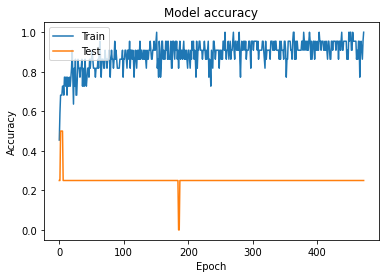

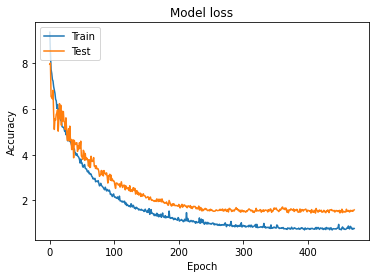

In [15]:
import matplotlib.pyplot as plt
import numpy as np 
from keras.metrics import categorical_crossentropy, categorical_accuracy

model = buildModel()

model.summary()

history = model.fit_generator(
  train_generator,
  epochs=EPOCHS,
  validation_data=validation_generator,
  shuffle=True,
  callbacks=CALLBACKS
)

model.save('./model.h5')

# Plot step by step movements of the accuracy metric

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



#**Testing**

## **Validation generator**

[[0 2]
 [1 1]]
0.25


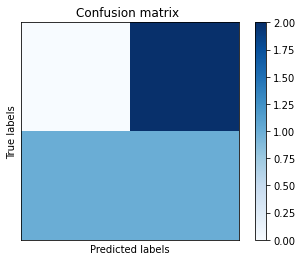

In [16]:

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from keras.models import load_model
loaded_model = buildModelFromDisk('./checkpoint.h5')


y_pred = loaded_model.predict_generator(validation_generator)
y_pred_argmax = [i.argmax() for i in y_pred]
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred_argmax)

print (cm)

total = sum(sum(cm))
hits = 0
for i in range(0,2):
  hits += cm[i][i]

print (hits / total)


plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

##**/tests folder**

prediction for /content/drive/My Drive/CAI propio/male_female_hemafrodita/test/male2.jpg
[[0.17020822 0.82979184]]
male
prediction for /content/drive/My Drive/CAI propio/male_female_hemafrodita/test/female2.jpg
[[0.47685432 0.5231457 ]]
male
prediction for /content/drive/My Drive/CAI propio/male_female_hemafrodita/test/female3.jpg
[[0.74630535 0.25369468]]
female
prediction for /content/drive/My Drive/CAI propio/male_female_hemafrodita/test/male3.jpg
[[0.1375339  0.86246604]]
male


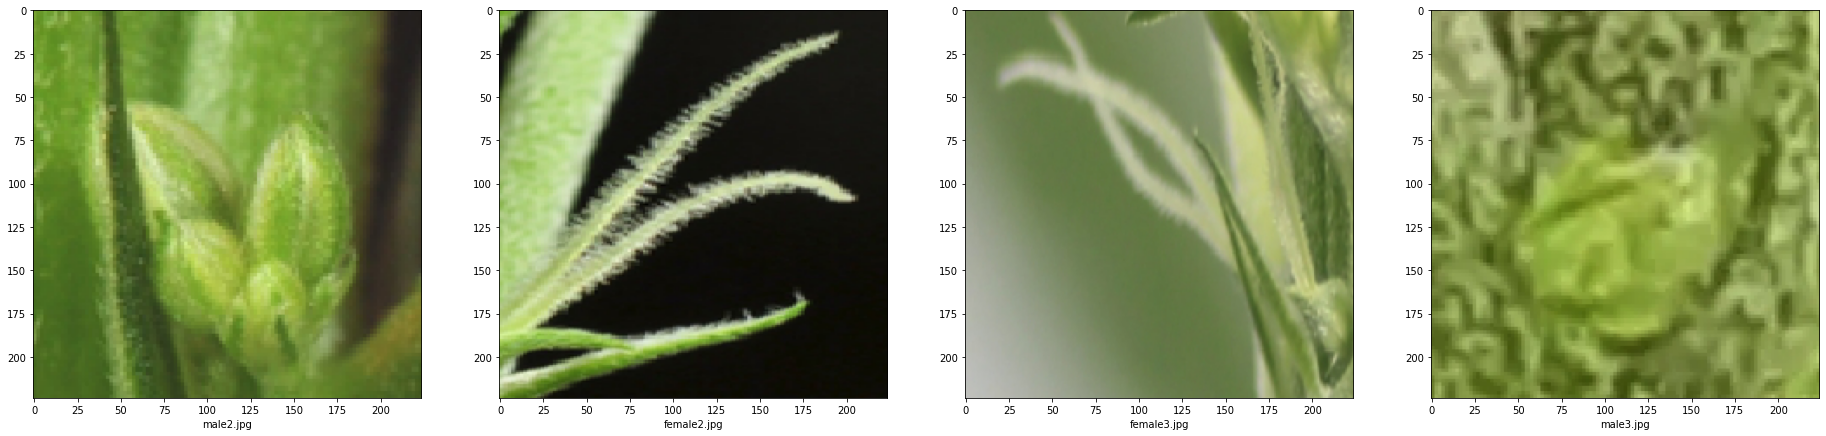

In [17]:
# SNIPPET TO LOAD DATA FROM DIRECTORY, FOR MANUAL WORK WITHOUT GENERATORS

import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

x_data = []
files = glob.glob (TEST_DIR + '/*.jpg') 

fig=plt.figure(figsize=(32, 32))
plotted_images = 1 

loaded_model = buildModelFromDisk('./checkpoint.h5')
predictions = []

for image_source in files:
    (image_original, image_tensor) = buildSampleFromDisk(image_source)

    fig.add_subplot(1, len(files), plotted_images) # subplot(rows, colums, currentIndexToPlot)
    plotted_images +=1
    
    image_label = image_source.split('/')[-1]
    plt.imshow(image_original)
    plt.xlabel(image_label)


    prediction = loaded_model.predict(image_tensor)
    print('prediction for ' + str(image_source))
    print(prediction)
    
    pred_label = prediction.argmax()

    if(pred_label == 0):
      print('female')
    elif(pred_label == 1):
      print('male')
  
